In [1]:
try:
    from linclab_utils import plot_utils
except ImportError as err:
    !pip install -q git+https://github.com/linclab/linclab_utils.git
    from linclab_utils import plot_utils

In [2]:
import wandb
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D
plot_utils.linclab_plt_defaults(font="Arial", fontdir="fonts")
from matplotlib.pyplot import cm
import re
import math

In [3]:
api = wandb.Api(timeout=19)

In [4]:
# Fetch runs for a specific project
def fetch_runs(api, entity, project_name, filters, order=None):
    if order:
        runs = api.runs(f"{entity}/{project_name}", filters=filters, order=order)
    else:
        runs = api.runs(f"{entity}/{project_name}", filters=filters)
    #print(f"Runs for project '{project_name}':")
    return runs

In [21]:
def same_config(config1, config2, keys=['normtype']):
    
    for key in keys:
        if config1[key] != config2[key]:
            return False

    # if config1['brightness_factor'] > np.abs(config1['brightness_factor_eval']):
    #     return False
    
    return True

In [22]:
runs_dict = dict()
runs_dict["runs_vanilla_dann"] = fetch_runs(api, entity='project_danns', project_name='Luminosity_Brightness_Robustness', filters={"config.dataset": "fashionmnist",
                                                            "config.homeostasis": 0, "config.normtype": 0,
                                                            "config.use_testset": True}, order="-summary_metrics.test_acc")
runs_dict["runs_vanilla_dann_layernorm"] = fetch_runs(api, entity='project_danns', project_name='Luminosity_Brightness_Robustness', filters={"config.dataset": "fashionmnist", 
                                                            "config.homeostasis": 0, "config.normtype": 1,
                                                            "config.use_testset": True}, order="-summary_metrics.test_acc")

100


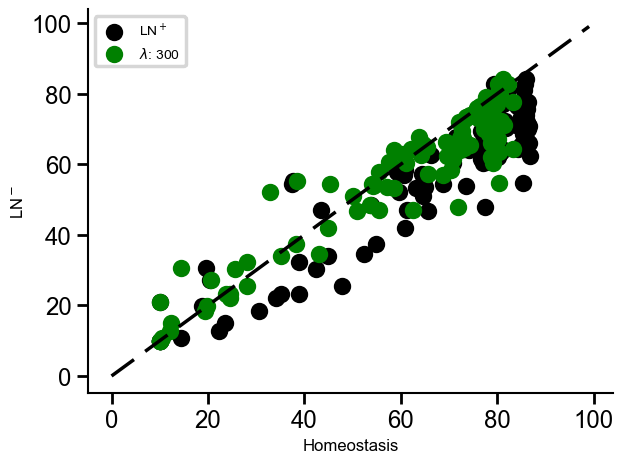

In [23]:
fig, ax = plt.subplots()

cmap = plt.get_cmap('viridis')

#lambs = [1, 10, 100, 1000]
#lambs = [150, 300, 400, 500]
lambs = [300]

values = np.linspace(0, 1, len(lambs))

top_n = len(runs_dict["runs_vanilla_dann"])
# print(f"Here: {top_n}")

activate_color = True
counter = 0

for top in range(top_n):

    vanilla_dann_acc = runs_dict["runs_vanilla_dann"][top].summary['test_acc']

    for rn in runs_dict["runs_vanilla_dann_layernorm"]:
        if same_config(rn.config, runs_dict["runs_vanilla_dann"][top].config, keys=['lr', 'wd','inhib_lrs', 'momentum', 'inhib_momentum', 'homeostasis']):
            plt.scatter(rn.summary['test_acc'], vanilla_dann_acc, color="black", label="LN$^+$" if activate_color else None)
            activate_color = False

for idx, lambdaa in enumerate(lambs):

    EI = fetch_runs(api, entity='project_danns', project_name='Luminosity_Brightness_Robustness', filters={"config.dataset": "fashionmnist", "config.homeostasis": 1, "config.normtype": 0,
                                                                        "config.use_testset": True, "config.task_opt_inhib": 1, "config.use_sep_bias_gain_lrs": 0,
                                                                        "config.homeostatic_annealing": 0 , "config.lambda_homeo": lambdaa, "config.implicit_homeostatic_loss":0}, order="-summary_metrics.test_acc")
    #print(len(EI))

    data = []

    color = cmap(values[idx])
    activate_color = True

    best_LN_plus = []
    best_LN_minus = []

    EI_lambdas = {}

    failed_runs = 0

    for top in range(top_n):
        best_acc_run_ln_config = 0

        vanilla_dann_acc = runs_dict["runs_vanilla_dann"][top].summary['test_acc']

        best_LN_minus.append(vanilla_dann_acc)
        EI_lambdas_temp = {}

        for rn in EI:
            if same_config(rn.config, runs_dict["runs_vanilla_dann"][top].config, keys=['lr', 'wd','inhib_lrs', 'momentum', 'inhib_momentum']):
                counter = counter +1 
                plt.scatter(rn.summary['test_acc'], vanilla_dann_acc, color="green", label=f"$\lambda$: {lambdaa}" if activate_color else None)
                activate_color = False


print(counter)
ax.set_xlabel(f"Homeostasis")
ax.set_ylabel("LN$^-$")
ax.legend(fontsize=10)
#ax.set_title(f'Brightness Factor {bright_factor}')
list_line = range(100)
ax.plot(list_line, list_line, label='y = x', color='black', linestyle='--')

/tmp/ipykernel_1585172/61779204.py:58: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  bp = ax.boxplot(np.array(data).T, patch_artist=True, boxprops=dict(color='black', facecolor='none'), medianprops=dict(linestyle='-', linewidth=2.5, color='black'),


failed runs: 0


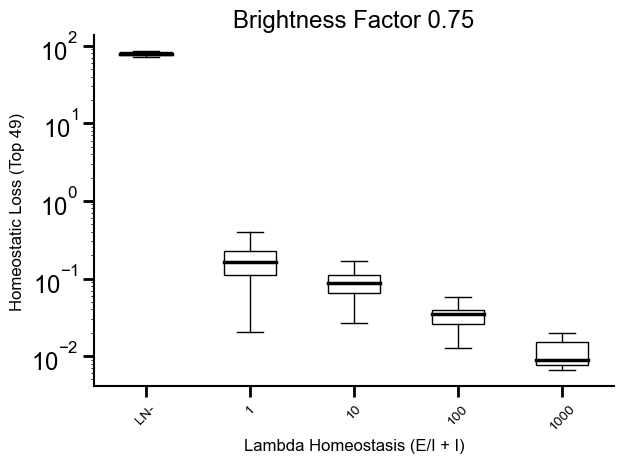

In [32]:
fig, ax = plt.subplots()

EI = fetch_runs(api, entity='project_danns', project_name='Luminosity_DeepDANN_ExhaustiveSearch_StrongExplicitLoss', filters={"config.dataset": "fashionmnist", 
                                                                    "config.brightness_factor": bright_factor, "config.homeostasis": 1, "config.normtype": 0,
                                                                    "config.use_testset": True, "config.task_opt_inhib": 1, "config.use_sep_bias_gain_lrs": 0,
                                                                    "config.homeostatic_annealing": 0 }, order="-summary_metrics.test_acc")


data = []

best_LN_plus = []
best_LN_minus = []

EI_lambdas = {}

failed_runs = 0

for top in range(top_n):
    best_acc_run_ln_config = 0

    vanilla_dann_acc = runs_dict["runs_vanilla_dann"][top].summary['test_local_loss']

    best_LN_minus.append(vanilla_dann_acc)
    #print(f"Model {top}: {vanilla_dann_acc}")
    EI_lambdas_temp = {}

    for rn in runs_dict["runs_vanilla_dann_layernorm"]:
        if same_config(rn.config, runs_dict["runs_vanilla_dann"][top].config, keys=['lr', 'wd','inhib_lrs', 'momentum', 'inhib_momentum', 'homeostasis']):
            if rn.summary['test_acc'] > best_acc_run_ln_config:
                best_acc_run_ln_config = rn.summary['test_acc']

    for rn in EI:
        if same_config(rn.config, runs_dict["runs_vanilla_dann"][top].config, keys=['lr', 'wd', 'momentum', 'inhib_momentum', 'inhib_lrs']):
            if rn.state == 'failed':
                failed_runs = failed_runs + 1
                continue
            if rn.config['lambda_homeo'] in EI_lambdas_temp.keys():
                EI_lambdas_temp[rn.config['lambda_homeo']].append(rn.summary['test_local_loss'])
            else:
                EI_lambdas_temp[rn.config['lambda_homeo']] = [rn.summary['test_local_loss']]

    best_LN_plus.append(best_acc_run_ln_config)

    for ky in EI_lambdas_temp.keys():
        if ky in EI_lambdas.keys():
            EI_lambdas[ky].extend(sorted(EI_lambdas_temp[ky])[-1:])
        else:
            EI_lambdas[ky] = sorted(EI_lambdas_temp[ky])[-1:]

data.extend([best_LN_plus])

sorted_keys = sorted(EI_lambdas.keys())

for ky in sorted_keys:
    EI_lambdas[ky] = [x for x in EI_lambdas[ky] if x != 'NaN']
    data.append(EI_lambdas[ky])

bp = ax.boxplot(np.array(data).T, patch_artist=True, boxprops=dict(color='black', facecolor='none'), medianprops=dict(linestyle='-', linewidth=2.5, color='black'),
                        showfliers=False)

sorted_keys = sorted(EI_lambdas.keys())
    #elements.append(bp)
# Create custom x-axis tick labels
label_keys = ['LN-']
label_keys.extend([str(el) for el in sorted_keys])
custom_xticks = [el for el in label_keys]
ax.set_xticks(np.arange(1, len(custom_xticks) + 1))
ax.set_xticklabels(custom_xticks, fontsize=10,  rotation=45)

ax.set_xlabel(f'Lambda Homeostasis (E/I + I)')
ax.set_ylabel(f'Homeostatic Loss (Top {top_n})')
ax.set_title(f'Brightness Factor {bright_factor}')
ax.set_yscale('log')
#plt.legend(loc='best', fontsize="10")

print(f'failed runs: {failed_runs}')


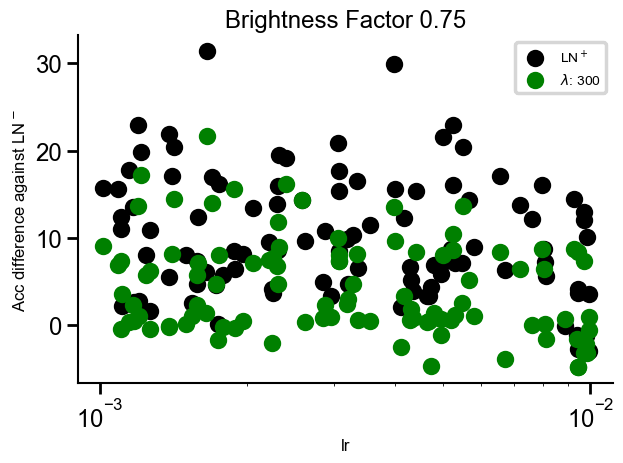

In [16]:
fig, ax = plt.subplots()

import re

# Regex pattern to extract wei and wix
pattern = r'wei=([-\d.eE]+), wix=([-\d.eE]+)'

cmap = plt.get_cmap('viridis')

#lambs = [1, 10, 100, 1000]
#lambs = [150, 300, 400, 500]
lambs = [300]

values = np.linspace(0, 1, len(lambs))

# inhib_lrs.wei
# inhib_lrs.wix

feature = 'lr'

top_n = len(runs_dict["runs_vanilla_dann"])
# print(f"Here: {top_n}")

activate_color = True

for top in range(top_n):

    vanilla_dann_acc = runs_dict["runs_vanilla_dann"][top].summary['test_acc']

    for rn in runs_dict["runs_vanilla_dann_layernorm"]:
        if same_config(rn.config, runs_dict["runs_vanilla_dann"][top].config, keys=['lr', 'wd','inhib_lrs', 'momentum', 'inhib_momentum', 'homeostasis']):
            #plt.scatter(rn.summary['test_acc'], vanilla_dann_acc, color="black", label="LN$^+$" if activate_color else None)

            # Search the pattern in the text
            # match = re.search(pattern, rn.config[feature])

            # if match:
            #     wei = float(match.group(1))
            #     wix = float(match.group(2))

            plt.scatter(rn.config[feature], rn.summary['test_acc'] - vanilla_dann_acc, color="black", label="LN$^+$" if activate_color else None)
            #plt.scatter(wei, rn.summary['test_acc'] - vanilla_dann_acc, color="black", label="LN$^+$" if activate_color else None)
            activate_color = False

for idx, lambdaa in enumerate(lambs):

    EI = fetch_runs(api, entity='project_danns', project_name='Luminosity_DeepDANN_ExhaustiveSearch', filters={"config.dataset": "fashionmnist", 
                                                                        "config.brightness_factor": bright_factor, "config.homeostasis": 1, "config.normtype": 0,
                                                                        "config.use_testset": True, "config.task_opt_inhib": 1, "config.use_sep_bias_gain_lrs": 0,
                                                                        "config.homeostatic_annealing": 0 , "config.lambda_homeo": lambdaa}, order="-summary_metrics.test_acc")
    # print(len(EI))

    data = []

    color = cmap(values[idx])
    activate_color = True

    best_LN_plus = []
    best_LN_minus = []

    EI_lambdas = {}

    failed_runs = 0

    for top in range(top_n):
        best_acc_run_ln_config = 0

        vanilla_dann_acc = runs_dict["runs_vanilla_dann"][top].summary['test_acc']

        best_LN_minus.append(vanilla_dann_acc)
        EI_lambdas_temp = {}

        for rn in EI:
            if same_config(rn.config, runs_dict["runs_vanilla_dann"][top].config, keys=['lr', 'wd','inhib_lrs', 'momentum', 'inhib_momentum']):
                # plt.scatter(rn.summary['test_acc'], vanilla_dann_acc, color=color, label=f"$\lambda$: {lambdaa}" if activate_color else None)

                # Search the pattern in the text
                # match = re.search(pattern, rn.config[feature])

                # if match:
                #     wei = float(match.group(1))
                #     wix = float(match.group(2))

                # plt.scatter(rn.config[feature], rn.summary['test_acc'] - vanilla_dann_acc, color="green", label=f"$\lambda$: {lambdaa}" if activate_color else None)
                plt.scatter(rn.config[feature], rn.summary['test_acc'] - vanilla_dann_acc, color="green", label=f"$\lambda$: {lambdaa}" if activate_color else None)
                #plt.scatter(wei, rn.summary['test_acc'] - vanilla_dann_acc, color="green", label=f"$\lambda$: {lambdaa}" if activate_color else None)
                activate_color = False



ax.set_xlabel(feature)
ax.set_ylabel("Acc difference against LN$^-$")
ax.legend(fontsize=10)
ax.set_title(f'Brightness Factor {bright_factor}')
ax.set_xscale('log')
# list_line = range(100)
# ax.set_xlim(60, 90)
# ax.set_ylim(-10, 10)
# ax.plot(list_line, list_line, label='y = x', color='black', linestyle='--')

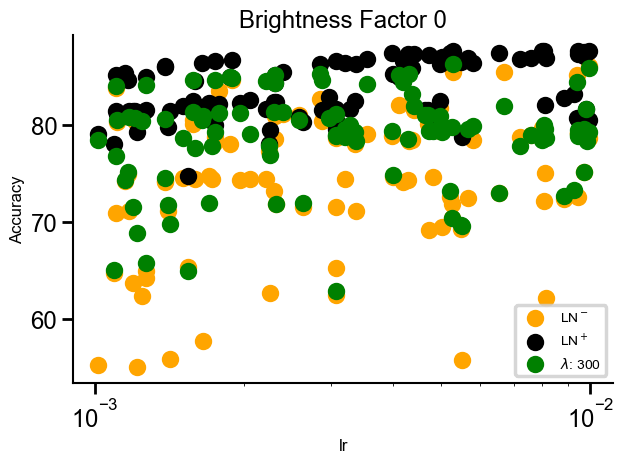

In [22]:
fig, ax = plt.subplots()

import re

# Regex pattern to extract wei and wix
pattern = r'wei=([-\d.eE]+), wix=([-\d.eE]+)'

cmap = plt.get_cmap('viridis')

lambs = [300]

values = np.linspace(0, 1, len(lambs))

# inhib_lrs.wei
# inhib_lrs.wix

feature = 'lr'

activate_color = True

for rn in runs_dict["runs_vanilla_dann"]:
    plt.scatter(rn.config[feature], rn.summary['test_acc'], color="orange", label="LN$^-$" if activate_color else None)
    activate_color = False

activate_color=True

for rn in runs_dict["runs_vanilla_dann_layernorm"]:
    plt.scatter(rn.config[feature], rn.summary['test_acc'], color="black", label="LN$^+$" if activate_color else None)
    activate_color = False

for idx, lambdaa in enumerate(lambs):

    EI = fetch_runs(api, entity='project_danns', project_name='Luminosity_DeepDANN_ExhaustiveSearch', filters={"config.dataset": "fashionmnist", 
                                                                        "config.brightness_factor": bright_factor, "config.homeostasis": 1, "config.normtype": 0,
                                                                        "config.use_testset": True, "config.task_opt_inhib": 1, "config.use_sep_bias_gain_lrs": 0,
                                                                        "config.homeostatic_annealing": 0 , "config.lambda_homeo": lambdaa}, order="-summary_metrics.test_acc")

    data = []

    color = cmap(values[idx])
    activate_color = True
    
    for rn in EI:
        plt.scatter(rn.config[feature], rn.summary['test_acc'], color="green", label=f"$\lambda$: {lambdaa}" if activate_color else None)
        activate_color = False



ax.set_xlabel(feature)
ax.set_ylabel("Accuracy")
ax.legend(fontsize=10)
ax.set_title(f'Brightness Factor {bright_factor}')
ax.set_xscale('log')

100


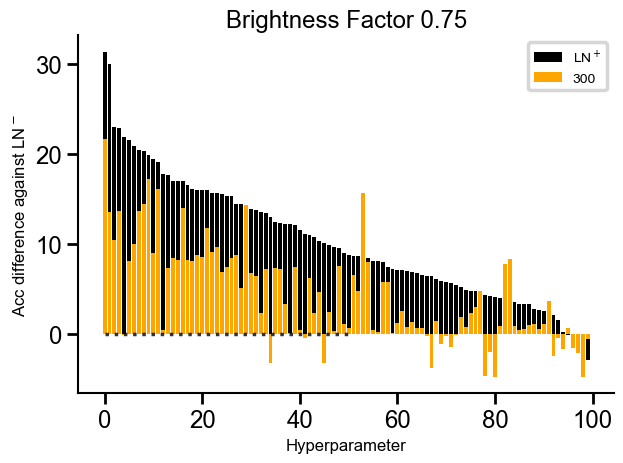

In [26]:
fig, ax = plt.subplots()

import re

# Regex pattern to extract wei and wix
pattern = r'wei=([-\d.eE]+), wix=([-\d.eE]+)'

cmap = plt.get_cmap('viridis')

#lambs = [1, 10, 100, 150, 300, 400, 500]
lambs=[300]
#lambs = [150, 300, 400, 500]
#lambs = [150, 300]

values = np.linspace(0, 1, len(lambs))

feature = 'hidden_layer_width'

top_n = len(runs_dict["runs_vanilla_dann"])
print(top_n)

activate_color = True



values = []

for top in range(top_n):

    vanilla_dann_acc = runs_dict["runs_vanilla_dann"][top].summary['test_acc']
    found = False

    for rn in runs_dict["runs_vanilla_dann_layernorm"]:
        if same_config(rn.config, runs_dict["runs_vanilla_dann"][top].config, keys=['lr', 'wd','inhib_lrs', 'momentum', 'inhib_momentum', 'homeostasis']):
            values.append(rn.summary['test_acc'] - vanilla_dann_acc)
            found = True
            break
        
    if not found:
        values.append(0)


vall = np.array(values)
sorted_indices = np.argsort(vall)[::-1]
res = np.array([vall[sorted_indices]])

# Bar positions on the X axis
x = np.arange(len(values))
# ax.bar(x, values[sorted_indices], label="LN$^+$")
ax.bar(x, vall[sorted_indices], label="LN$^+$", color='black')

for idx, lambdaa in enumerate(lambs):

    EI = fetch_runs(api, entity='project_danns', project_name='Luminosity_DeepDANN_ExhaustiveSearch', filters={"config.dataset": "fashionmnist", 
                                                                        "config.brightness_factor": bright_factor, "config.homeostasis": 1, "config.normtype": 0,
                                                                        "config.use_testset": True, "config.task_opt_inhib": 1, "config.use_sep_bias_gain_lrs": 0,
                                                                        "config.homeostatic_annealing": 0 , "config.lambda_homeo": lambdaa}, order="-summary_metrics.test_acc")

    data = []

    color = cmap(values[idx])

    failed_runs = 0
    values = []
    for top in range(top_n):
        
        vanilla_dann_acc = runs_dict["runs_vanilla_dann"][top].summary['test_acc']
        found = False
        
        for idx_delete, rn in enumerate(EI):
            
            if same_config(rn.config, runs_dict["runs_vanilla_dann"][top].config, keys=['lr', 'wd','inhib_lrs', 'momentum', 'inhib_momentum']):
                values.append(rn.summary['test_acc'] - vanilla_dann_acc)
                found = True
                break
        
        if not found:
            values.append(0)

    # Bar positions on the X axis
    x = np.arange(len(values))
    vall = np.array(values)
    res = np.append(res, [vall[sorted_indices]], axis=0)
    ax.bar(x, vall[sorted_indices], label=f"{lambdaa}", color='orange')


    

ax.set_xlabel("Hyperparameter")
ax.set_ylabel("Acc difference against LN$^-$")
ax.legend(fontsize=10)
ax.set_title(f'Brightness Factor {bright_factor}')
list_line = range(52)
# ax.set_xlim(60, 90)
# ax.set_ylim(-10, 10)
ax.plot(list_line, np.zeros(52), label='y = x', color='black', linestyle='dotted', alpha=0.8)

100


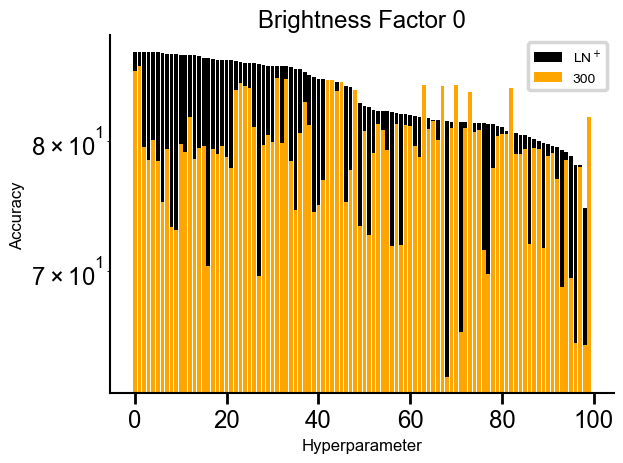

In [30]:
fig, ax = plt.subplots()

import re

# Regex pattern to extract wei and wix
pattern = r'wei=([-\d.eE]+), wix=([-\d.eE]+)'

cmap = plt.get_cmap('viridis')

lambs=[300]

values = np.linspace(0, 1, len(lambs))

feature = 'hidden_layer_width'

top_n = len(runs_dict["runs_vanilla_dann"])
print(top_n)

activate_color = True



values = []

for top in range(top_n):

    vanilla_dann_acc = runs_dict["runs_vanilla_dann"][top].summary['test_acc']
    found = False

    for rn in runs_dict["runs_vanilla_dann_layernorm"]:
        if same_config(rn.config, runs_dict["runs_vanilla_dann"][top].config, keys=['lr', 'wd','inhib_lrs', 'momentum', 'inhib_momentum', 'homeostasis']):
            values.append(rn.summary['test_acc'])
            found = True
            break
        
    if not found:
        values.append(0)


vall = np.array(values)
sorted_indices = np.argsort(vall)[::-1]
res = np.array([vall[sorted_indices]])

# Bar positions on the X axis
x = np.arange(len(values))
# ax.bar(x, values[sorted_indices], label="LN$^+$")
ax.bar(x, vall[sorted_indices], label="LN$^+$", color='black')

for idx, lambdaa in enumerate(lambs):

    EI = fetch_runs(api, entity='project_danns', project_name='Luminosity_DeepDANN_ExhaustiveSearch', filters={"config.dataset": "fashionmnist", 
                                                                        "config.brightness_factor": bright_factor, "config.homeostasis": 1, "config.normtype": 0,
                                                                        "config.use_testset": True, "config.task_opt_inhib": 1, "config.use_sep_bias_gain_lrs": 0,
                                                                        "config.homeostatic_annealing": 0 , "config.lambda_homeo": lambdaa}, order="-summary_metrics.test_acc")

    data = []

    color = cmap(values[idx])

    failed_runs = 0
    values = []
    for top in range(top_n):
        
        vanilla_dann_acc = runs_dict["runs_vanilla_dann"][top].summary['test_acc']
        found = False
        
        for idx_delete, rn in enumerate(EI):
            
            if same_config(rn.config, runs_dict["runs_vanilla_dann"][top].config, keys=['lr', 'wd','inhib_lrs', 'momentum', 'inhib_momentum']):
                values.append(rn.summary['test_acc'])
                found = True
                break
        
        if not found:
            values.append(0)

    # Bar positions on the X axis
    x = np.arange(len(values))
    vall = np.array(values)
    res = np.append(res, [vall[sorted_indices]], axis=0)
    ax.bar(x, vall[sorted_indices], label=f"{lambdaa}", color='orange')


    

ax.set_xlabel("Hyperparameter")
ax.set_ylabel("Accuracy")
ax.legend(fontsize=10)
ax.set_title(f'Brightness Factor {bright_factor}')
list_line = range(52)
# ax.set_xlim(60, 90)
# ax.set_ylim(-10, 10)
ax.plot(list_line, np.zeros(52), label='y = x', color='black', linestyle='dotted', alpha=0.8)
ax.set_yscale('log')